In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
image_folder = '/content/drive/MyDrive/RESEARCH/models/filesFolder/NLMCXR_png'
df_path = '/content/drive/MyDrive/RESEARCH/models/filesFolder/NLMCXR_reports/ecgen-radiology'

Check how many images are there and how many report files are there

In [4]:
print("there are {} number of reports in the data ".format(len(os.listdir(df_path))))
print("there are {} number of x-rays in the data ".format(len(os.listdir(image_folder)))) 

there are 3955 number of reports in the data 
there are 7488 number of x-rays in the data 


In [ ]:
no_images = [] #stores the no. of images
for file in os.listdir(df_path):
  report_file = os.path.join(df_path,file)
  with open(report_file, 'r') as f:  #reading the xml data
    data = f.read()
  regex = r"parentImage id.*" #getting all the image names
  k  = re.findall(regex,data)
  temp = len(k)
  no_images.append(temp)

In [ ]:
no_images = np.array(no_images)
print("The max no. of images found associated with a report: %i"%(no_images.max()))
print("The min no. of images found associated with a report: %i"%(no_images.min()))

The max no. of images found associated with a report: 5
The min no. of images found associated with a report: 0


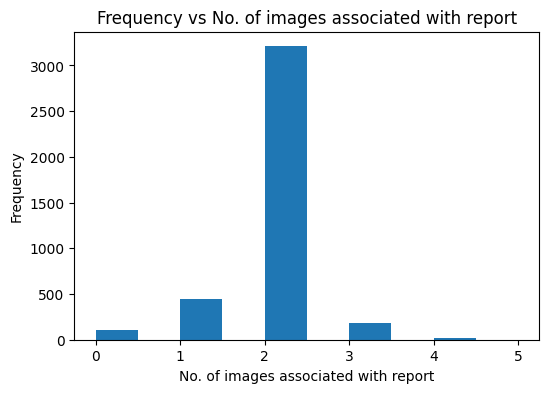

Image Value_counts

2    3208
1     446
3     181
0     104
4      15
5       1
dtype: int64


In [ ]:
plt.figure(figsize = (6,4))
ax = pd.Series(no_images).plot(kind='hist')
ax.set_xlabel('No. of images associated with report')
ax.set_title("Frequency vs No. of images associated with report")
plt.show()
print("Image Value_counts\n")
print(pd.Series(no_images).value_counts())

We can see that the maximum number of images associated with a report can be 5 while the minimum is 0. We will extract all the information part ie comparison, indication, findings and impression part of the report and the corresponding 2 images (we will take 2 images as input as 2 images are highest frequecy of being associated with a report) of the concerned report to a dataframe with xml report file name. For images more than 2, we will creat new datapoint with new image and same info.

In [ ]:
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [ ]:
def get_info(xml_data,info): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  regex = r"\""  +info +r"\".*" 
  k = re.findall(regex,xml_data)[0] #finding info part of the report

  regex = r"\>.*\<"
  k = re.findall(regex,k)[0] #removing info string and /AbstractText>'

  regex = r"\d." 
  k = re.sub(regex,"",k) #removing all values like "1." and "2." etc

  regex = r"X+"
  k = re.sub(regex,"",k) #removing words like XXXX

  regex = r" \."
  k = re.sub(regex,"",k) #removing singular fullstop ie " ."

  regex = r"[^.a-zA-Z]" 
  k = re.sub(regex," ",k) #removing all special characters except for full stop

  regex = r"\."
  k = re.sub(regex," .",k) #adding space before fullstop
  k = decontracted(k) #perform decontraction
  k = k.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
  k = " ".join(k.split()) #removes unwanted spaces
  if k=="": #if the resulting sentence is an empty string return null value
    k = np.nan
  return k

In [ ]:
def get_final(data):
  """
  given an xml data returns "COMPARISON","INDICATION","FINDINGS","IMPRESSION" part of the data
  """
  try: #assigning null values to the ones that don't have the concerned info
      comparison = get_info(data, "COMPARISON")
  except:
    comparison = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    indication = get_info(data, "INDICATION")
  except:
    indication = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    finding = get_info(data,"FINDINGS")
  except:
    finding = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    impression = get_info(data, "IMPRESSION")
  except:
    impression = np.nan;

  return comparison,indication,finding,impression

In [ ]:
def get_df():
  """
  Given an xml data, it will extract the two image names and corresponding info text and returns a dataframe
  """
  im1 = [] #there are 2 images associated with a report
  im2 = []
  #stores info
  comparisons = []
  indications = []
  findings = []
  impressions = [] 
  report = [] #stores xml file name
  for file in tqdm(os.listdir(df_path)):
    report_file = os.path.join(df_path,file)
    with open(report_file, 'r') as f:  #reading the xml data
      data = f.read()
  
    regex = r"parentImage id.*" #getting all the image names
    k  = re.findall(regex,data)

    if len(k)==2: 
      regex = r"\".*\"" #getting the name
      image1 = re.findall(regex,k[0])[0]
      image2 = re.findall(regex,k[1])[0]

      image1 = re.sub(r"\"","",image1)
      image2 = re.sub(r"\"","",image2)

      image1 = image1.strip()+".png"
      image2 = image2.strip()+".png"
      im1.append(image1)
      im2.append(image2)

      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name

    
    elif len(k)<2:
      regex = r"\".*\"" #getting the name
      try: #if the exception is raised means no image file name was found
        image1 = re.findall(regex,k[0])[0]
        image1 = re.sub(r"\"","",image1) #removing "
        image2 = np.nan

        image1 = image1.strip()+".png"
      except:
        image1 = np.nan
        image2 = np.nan


      im1.append(image1)
      im2.append(image2)
      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name
    
    else: #if there are more than 2 images concerned with report
      comparison,indication,finding,impression = get_final(data)

      for i in range(len(k)-1):
        regex = r"\".*\"" #getting the name
        image1 = re.findall(regex,k[i])[0] #re.findall returns a list
        image2 = re.findall(regex,k[i+1])[0] 

        image1 = re.sub(r"\"","",image1) #removing "
        image2 = re.sub(r"\"","",image2) #removing "

        image1 = image1.strip()+".png"
        image2 = image2.strip()+".png"

        im1.append(image1)
        im2.append(image2)
        comparisons.append(comparison)
        indications.append(indication)
        findings.append(finding)
        impressions.append(impression)
        report.append(file) #xml file name
    
  df = pd.DataFrame({"image_1":im1,"image_2":im2,"comparison":comparisons,"indication":indications,"findings":findings,"impression":impressions,"xml file name":report})
  return df

In [ ]:
%%time
df = get_df()

100%|██████████| 3955/3955 [00:08<00:00, 488.24it/s]

CPU times: user 1.4 s, sys: 485 ms, total: 1.88 s
Wall time: 8.84 s


In [ ]:
#df.to_pickle("/content/drive/MyDrive/RESEARCH/models/filesFolder/df.pkl")
df = pd.read_pickle("/content/drive/My Drive/Medical image Reporting/df.pkl")
df.shape

(4169, 7)

In [ ]:
df.head()

,image_1,image_2,comparison,indication,findings,impression,xml file name
0,CXR1317_IM-0205-1001.png,CXR1317_IM-0205-1002.png,none,the left lateral rib pain gunshot wound years ago,lungs are clear . there is minimal atelectasis...,minimal atelectasis left base no acute abnorma...,1317.xml
1,CXR1939_IM-0609-1001.png,NaN,none,year old female with chest pain,lungs are clear . heart size normal . no pneum...,clear lungs . no acute cardiopulmonary abnorma...,1939.xml
2,CXR1970_IM-0632-1001.png,CXR1970_IM-0632-2001.png,NaN,year old male . headache . hypertension .,apparent cardiomegaly at partially accentuated...,borderline cardiomegaly without heart failure .,1970.xml
3,CXR1261_IM-0177-1001.png,CXR1261_IM-0177-2001.png,none,syncope,mild cardiomegaly . normal pulmonary vasculari...,mild cardiomegaly .,1261.xml
4,CXR1963_IM-0629-1001.png,CXR1963_IM-0629-2001.png,none .,mvc .,images . heart size and pulmonary vascular eng...,no acute cardiopulmonary abnormality identified .,1963.xml


In [ ]:
print("columns\t\t%missing values")
print('-'*30)
print(df.isnull().sum()*100/df.shape[0] )#percentage missing values

columns		%missing values
------------------------------
image_1           2.494603
image_2          13.192612
comparison       33.605181
indication        6.308467
findings         13.504438
impression        0.839530
xml file name     0.000000
dtype: float64


We can see that there are many missing values in the data. We could remove all rows where image_1 and impression values are null since they represent below 5% of the total datapoints.col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = ' ' + df.impression + ' '
df['impression_ip'] = ' ' + df.impression
df['impression_op'] = df.impression + ' ' 
print(df.shape)
df.head(2)col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = ' ' + df.impression + ' '
df['impression_ip'] = ' ' + df.impression
df['impression_op'] = df.impression + ' ' 
print(df.shape)
df.head(2)col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = ' ' + df.impression + ' '
df['impression_ip'] = ' ' + df.impression
df['impression_op'] = df.impression + ' ' 
print(df.shape)
df.head(2)col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = ' ' + df.impression + ' '
df['impression_ip'] = ' ' + df.impression
df['impression_op'] = df.impression + ' ' 
print(df.shape)
df.head(2)col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = ' ' + df.impression + ' '
df['impression_ip'] = ' ' + df.impression
df['impression_op'] = df.impression + ' ' 
print(df.shape)col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = ' ' + df.impression + ' '
df['impression_ip'] = ' ' + df.impression
df['impression_op'] = df.impression + ' ' 
print(df.shape)col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = ' ' + df.impression + ' '
df['impression_ip'] = ' ' + df.impression
df['impression_op'] = df.impression + ' ' 
print(df.shape)

In [ ]:
df.drop(df[(df['impression'].isnull())|(df['image_1'].isnull())].index,inplace=True)
df = df.reset_index(drop=True).copy()
print("%i datapoints were removed.\nFinal no. of datapoints: %i"%(4169-df.shape[0],df.shape[0]))

136 datapoints were removed.
Final no. of datapoints: 4033


There are missing values in image_2. For that we can use the same image file in image_1. We will also check for image size for both of them.

In [ ]:

%%time
df.loc[df.image_2.isnull(),'image_2'] = df[df.image_2.isnull()]['image_1'].values
im1_size = []
im2_size = []
for index,row in df.iterrows():
  im1_size.append( cv2.imread(os.path.join(image_folder,row.get('image_1'))).shape[:2])
  im2_size.append(cv2.imread(os.path.join(image_folder,row.get('image_2'))).shape[:2])

CPU times: user 53.1 s, sys: 4.83 s, total: 58 s
Wall time: 37min 38s


In [ ]:
df['im1_height'] = [i[0] for i in im1_size]
df['im1_width'] = [i[1] for i in im1_size]
df['im2_height'] = [i[0] for i in im2_size]
df['im2_width'] = [i[1] for i in im2_size]

In [ ]:
df.head(2)

,image_1,image_2,comparison,indication,findings,impression,xml file name,im1_height,im1_width,im2_height,im2_width
0,CXR1317_IM-0205-1001.png,CXR1317_IM-0205-1002.png,none,the left lateral rib pain gunshot wound years ago,lungs are clear . there is minimal atelectasis...,minimal atelectasis left base no acute abnorma...,1317.xml,517,512,582,512
1,CXR1939_IM-0609-1001.png,CXR1939_IM-0609-1001.png,none,year old female with chest pain,lungs are clear . heart size normal . no pneum...,clear lungs . no acute cardiopulmonary abnorma...,1939.xml,512,512,512,512


In [6]:

#df.to_pickle("/content/drive/MyDrive/RESEARCH/models/filesFolder/df_final.pkl")
df = pd.read_pickle("/content/drive/MyDrive/RESEARCH/models/filesFolder/df_final.pkl")
df.shape

(4033, 11)

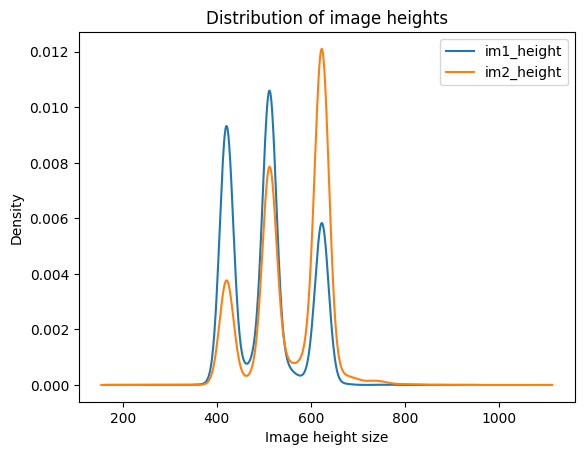



Value Counts of image_1 heights:

420    1130
512     926
624     674
511     234
618      87
Name: im1_height, dtype: int64

 ************************************************** 

Value Counts of image_2 heights:

624    1455
512     714
420     453
511     218
618      89
Name: im2_height, dtype: int64


In [ ]:

ax = df[['im1_height','im2_height']].plot(kind='kde')
ax.set_title("Distribution of image heights")
ax.set_xlabel("Image height size")
plt.show()

print("\n\nValue Counts of image_1 heights:\n")
print(df.im1_height.value_counts()[:5])
print("\n","*"*50,"\n")
print("Value Counts of image_2 heights:\n")
print(df.im2_height.value_counts()[:5])

We can observe that 420 is the most common height for image_1 while for image_2 is 624. The next common for both of the images is 512.

In [ ]:
print("Value Counts of image_1 widths:\n")
print(df.im1_width.value_counts()[:5])
print("\n","*"*50,"\n")
print("Value Counts of image_2 widths:\n")
print(df.im2_width.value_counts()[:5])

Value Counts of image_1 widths:

512    4033
Name: im1_width, dtype: int64

 ************************************************** 

Value Counts of image_2 widths:

512    4033
Name: im2_width, dtype: int64


Width for both of the images have only 1 unique value for all datapoints and that is 512. Since pretrained models are modelled for square-sized images we can choose 512*512 as the specified size of the image. Hence we can resize all images into 512*512 shape.

Now we will print some sample datapoints with corresponding images and captions associated with that datapoint.

In [ ]:

def show_image_captions(df = df,image_folder = image_folder,sample = 3):
  """
  given the df, samples datapoints and prints the images and caption
  df: dataframe
  image_folder: folder which contains images
  """
  k = df.sample(sample)
  i=1
  for index,row in k.iterrows():
    image_1 = cv2.imread(os.path.join(image_folder,row.get('image_1')))
    image_2 = cv2.imread(os.path.join(image_folder,row.get('image_2')))

    plt.figure(figsize = (12,8)) #setting the figure size
    plt.subplot(121) #first x-ray
    plt.imshow(image_1,aspect='auto')

    plt.subplot(122) #2nd x-ray
    plt.imshow(image_2, aspect = 'auto')
    print("%i)\n"%(i))
    i+=1
    plt.show() #printing the image
    print("\n","Comparison: ",row.get('comparison'))
    print("\n","Indication: ",row.get('indication'))
    print("\n","Findings: ",row.get('findings'))
    print("\n","Impression: ",row.get('impression'),"\n\n","*"*150,"\n\n")

1)



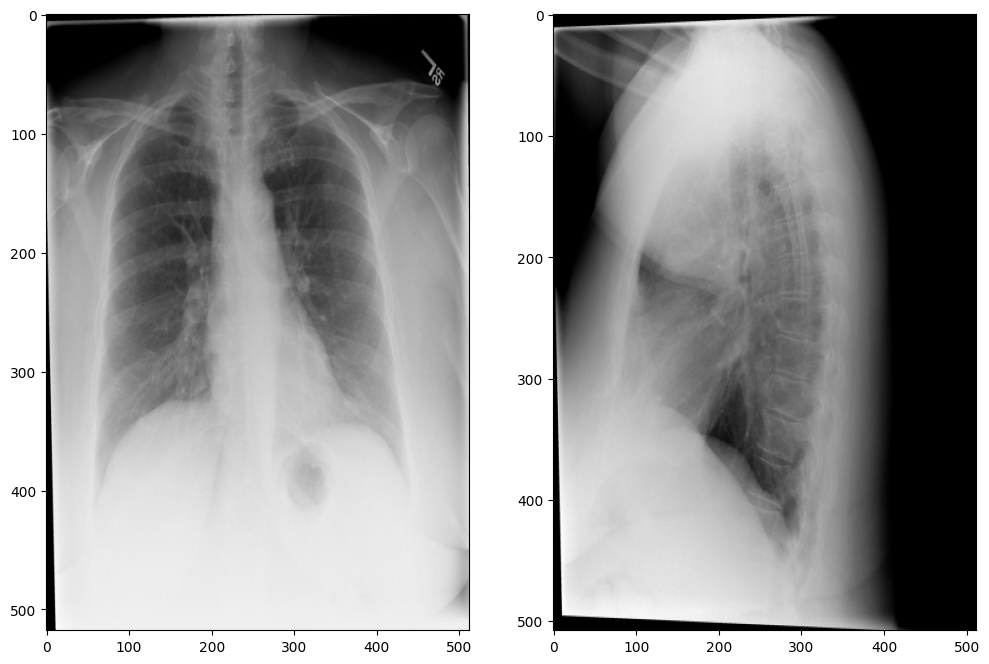


 Comparison:  none .

 Indication:  left arm back shoulder pain .

 Findings:  the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size . the lungs are clear of focal airspace disease pneumothorax or pleural effusion . there are no acute bony findings .

 Impression:  no acute cardiopulmonary findings . 

 ****************************************************************************************************************************************************** 


2)



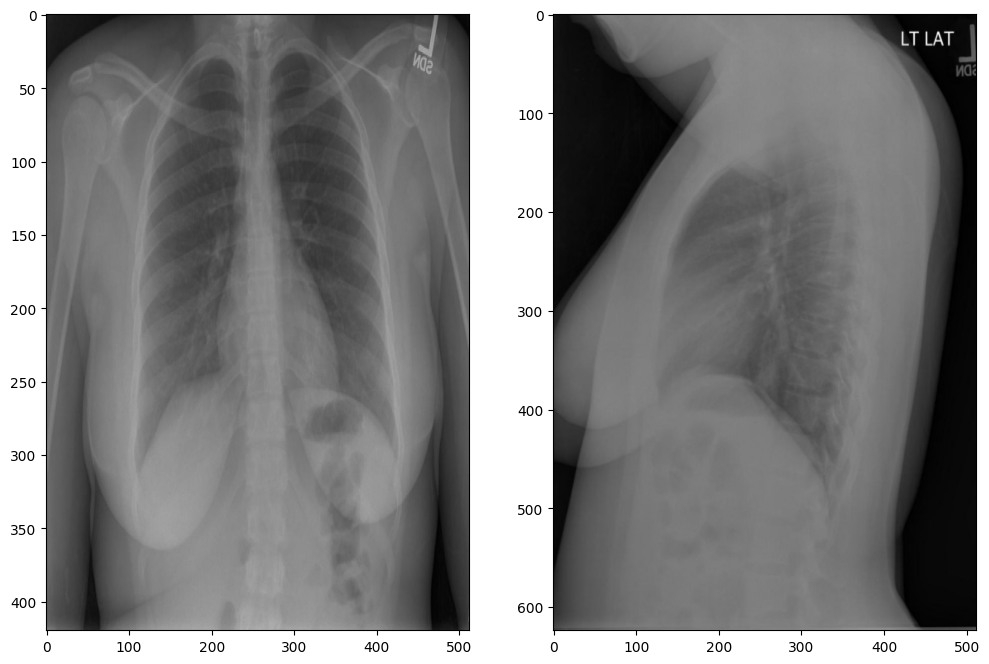


 Comparison:  none .

 Indication:  dyspnea

 Findings:  cardiomediastinal silhouette is within normal limits of size and appearance . the pulmonary vascularity is unremarkable . lungs are expanded and clear of airspace disease . negative for pneumothorax or pleural effusion . limited bone evaluation reveals no acute abnormality . there is incompletely evaluated lumbar levoscoliosis .

 Impression:  no acute cardiopulmonary abnormality . 

 ****************************************************************************************************************************************************** 


3)



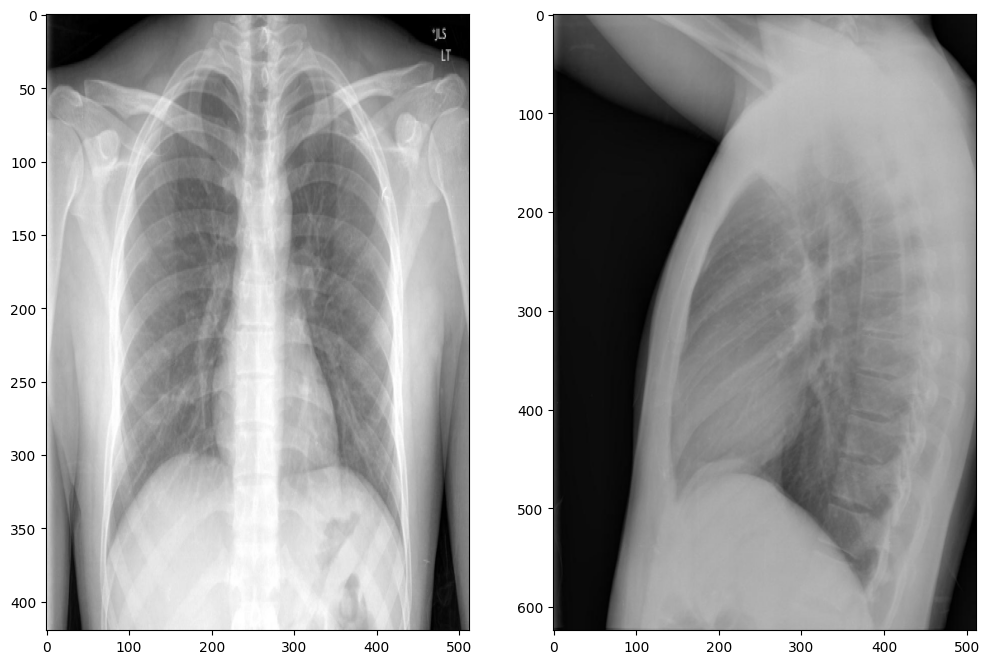


 Comparison:  none .

 Indication:  syncope .

 Findings:  the heart is normal in size and contour . there is no mediastinal widening . the lungs are clear bilaterally . no large pleural effusion or pneumothorax . the are intact .

 Impression:  no acute cardiopulmonary abnormalities . 

 ****************************************************************************************************************************************************** 




In [ ]:

#showing sample 3 datapoints
show_image_captions()

Wordcloud of Impressions

In [ ]:
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS 
#getting wordclouds
#https://www.geeksforgeeks.org/generating-word-cloud-python/
temp = df.loc[:,'impression'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable
words = ""
for i in temp.values:
  k = i.split()
  words+= " ".join(k) + " "
word = words.strip()
wc = WordCloud(width = 1024, height = 720, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 15,).generate(words) 

del k,words,temp

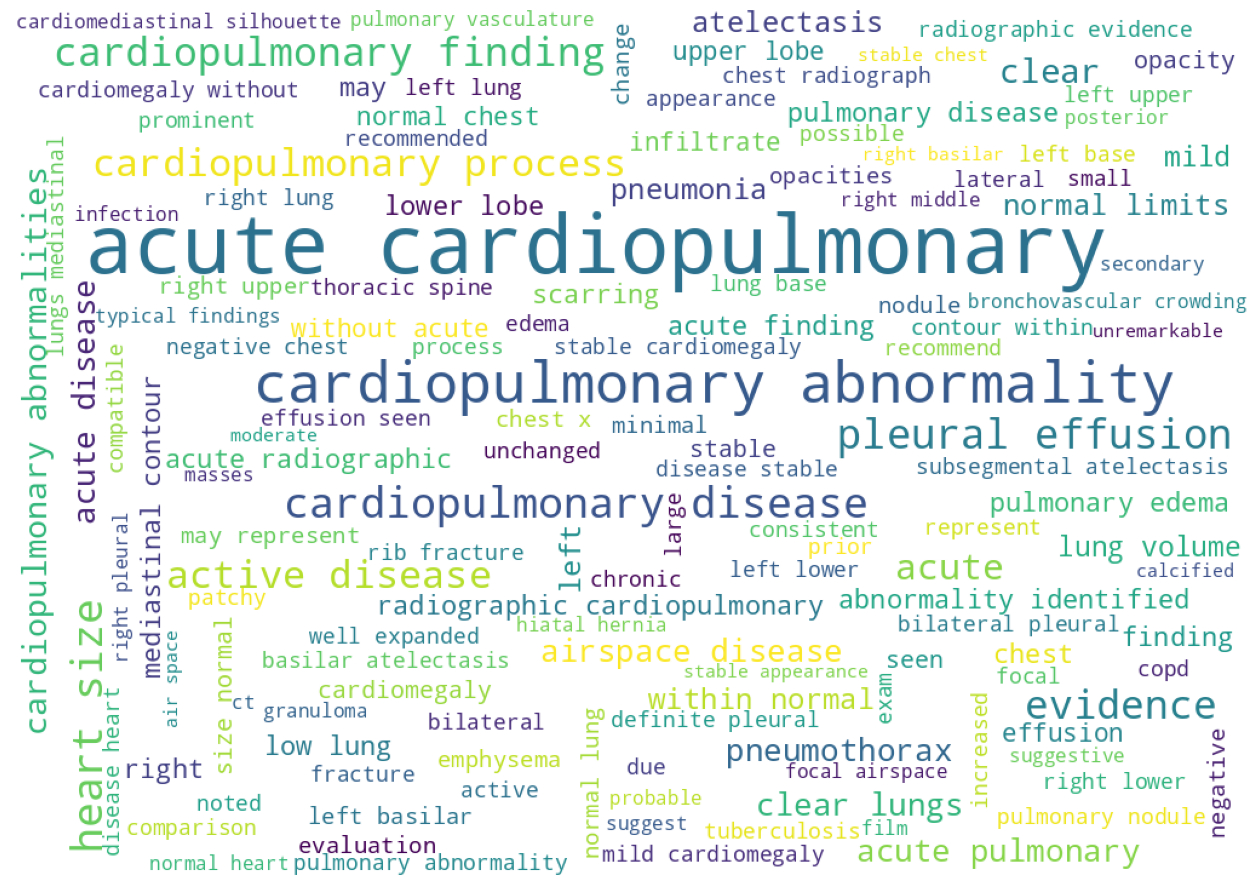

In [ ]:
plt.figure(figsize = (16,16))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [7]:
df.head()

,image_1,image_2,comparison,indication,findings,impression,xml file name,im1_height,im1_width,im2_height,im2_width
0,CXR1317_IM-0205-1001.png,CXR1317_IM-0205-1002.png,none,the left lateral rib pain gunshot wound years ago,lungs are clear . there is minimal atelectasis...,minimal atelectasis left base no acute abnorma...,1317.xml,517,512,582,512
1,CXR1939_IM-0609-1001.png,CXR1939_IM-0609-1001.png,none,year old female with chest pain,lungs are clear . heart size normal . no pneum...,clear lungs . no acute cardiopulmonary abnorma...,1939.xml,512,512,512,512
2,CXR1970_IM-0632-1001.png,CXR1970_IM-0632-2001.png,NaN,year old male . headache . hypertension .,apparent cardiomegaly at partially accentuated...,borderline cardiomegaly without heart failure .,1970.xml,508,512,512,512
3,CXR1261_IM-0177-1001.png,CXR1261_IM-0177-2001.png,none,syncope,mild cardiomegaly . normal pulmonary vasculari...,mild cardiomegaly .,1261.xml,420,512,624,512
4,CXR1963_IM-0629-1001.png,CXR1963_IM-0629-2001.png,none .,mvc .,images . heart size and pulmonary vascular eng...,no acute cardiopulmonary abnormality identified .,1963.xml,511,512,512,512


In [8]:
#check the lengths of reports
length=[]
for report in df["impression"]:
  try:
    length.append(len(report.split()))
  except:
    pass
length=np.array(length)
print("the mean lengths of reports is ",np.mean(length))
print("the 80th percentile lengths of reports is ",np.percentile(length,80))
print("the 90th percentile lengths of reports is ",np.percentile(length,90))
print("the 99th percentile lengths of reports is ",np.percentile(length,99))
print("the maximum value of lengths of reports is ",np.max(length))

the mean lengths of reports is  11.627076617902306
the 80th percentile lengths of reports is  16.0
the 90th percentile lengths of reports is  27.0
the 99th percentile lengths of reports is  58.679999999999836
the maximum value of lengths of reports is  133
